In [60]:
import math
import io
import torch
from torchvision import transforms
import numpy as np
import pickle
import re
import scipy.stats as st
import PIL
from collections import Counter
from PIL import Image
from PIL import ImageChops
import imageio
from pytorch_msssim import ssim, ms_ssim
import matplotlib.pyplot as plt
from statistics import mean
import compressai


In [2]:
from compressai.zoo import bmshj2018_factorized
from compressai.dna_entropy_coding.coder import Coder
from ipywidgets import interact, widgets

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Image extraction

In [3]:
def get_kodim_tensor(img_number): 
    img_name = '/kodim{:02d}.png'.format(img_number)
    img = Image.open('./assets'+ img_name).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [92]:
def get_learningbased_tensor(img_number, quality):
    path = 'assets/learningbased'
    img_name = '/{}kodim{:02d}.png'.format(quality, img_number)
    img = Image.open(path+ img_name).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [5]:
def get_learningbased_dna(img_number, quality):
    path = 'assets/learningbased'
    dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
    fasta_file = open(path + dna_name)
    dna = fasta_file.read()
    fasta_file.close()
    return dna


In [80]:
def get_anchor_tensor(anchor, img_number, quality): 
    '''
    Inputs : 
        anchor = int (1 or 3) 
        quality = int (1 to 8)
        img_number = int (1 to 24)
    '''
    anchor_path = 'assets/anchor' + str(anchor)
    img_name = '/{}kodim{:02d}.jpeg'.format(quality, img_number)
    img = Image.open(anchor_path+ img_name).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [81]:
def get_anchor_dna(anchor, img_number, quality): 
    anchor_path = 'assets/anchor' + str(anchor)
    dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
    fasta_file = open(anchor_path + dna_name)
    dna = fasta_file.read()
    fasta_file.close()
    return dna

In [82]:
def get_benchmark_tensor(img_number, quality):
    img_path = 'assets/benchmarkcodec/'
    img_name = '{}kodim{:02d}.jpeg'.format(quality, img_number)
    img = Image.open(img_path + img_name).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [9]:
def get_benchmark_dna(img_number, quality): 
    anchor_path = 'assets/benchmarkcodec'
    dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
    fasta_file = open(anchor_path + dna_name)
    dna = fasta_file.read()
    fasta_file.close()
    return dna

### DNA CG contents

In [10]:
def CG_content(dna) : 
    return 100*(dna.count("C")+dna.count("G"))/len(dna)

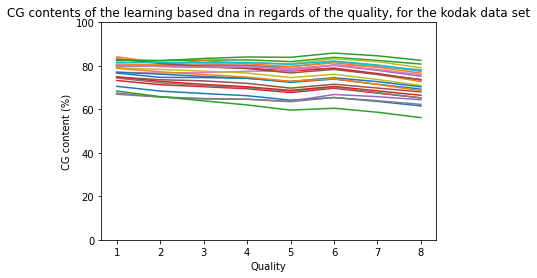

In [17]:
def learningbased_cg_contents(): 
    for i in range(1,25): 
        cg = []
    
        for q in range(1,9): 
            dna = get_learningbased_dna(i, q)
            cg.append(CG_content(dna))
            
        #plt.plot(range(1,9), cg, label='Im' + str(i))
        plt.plot(range(1,9), cg)
        
    plt.xlabel('Quality')
    plt.ylabel('CG content (%)')
    plt.title('CG contents of the learning based dna in regards of the quality, for the kodak data set' )
    plt.ylim(0, 100) 
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('plots/cg_learningbased.jpeg', bbox_inches='tight')
    plt.show()
    
learningbased_cg_contents()
    

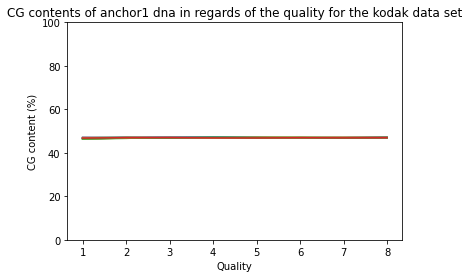

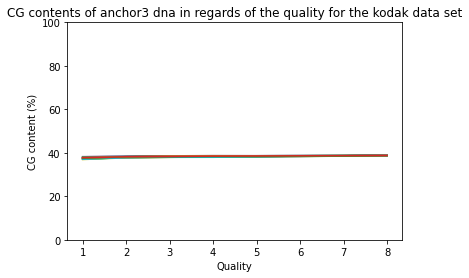

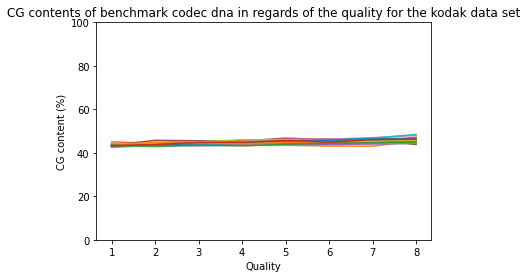

Invalid anchor : blabla. The options are : anchor1, anchor3, benchmark codec


In [18]:
def anchor_cg_contents(anchor): 
    for i in range(1,25): 
        cg = [] 
            
        for q in range(1,9): 
            if(anchor == 'anchor1'):
                dna = get_anchor_dna(1, i, q)
            elif(anchor == 'anchor3'):
                dna = get_anchor_dna(3, i, q)
            elif(anchor == 'benchmark codec'):
                dna = get_benchmark_dna(i, q)
            else: 
                print('Invalid anchor : '  + anchor + '. The options are : anchor1, anchor3, benchmark codec')
                return
            cg.append(CG_content(dna))
            
        plt.plot(range(1,9), cg)
        #plt.plot(range(1,9), cg, label='Im' + str(i))
        
    plt.xlabel('Quality')
    plt.ylabel('CG content (%)')
    plt.title('CG contents of ' + anchor +' dna in regards of the quality for the kodak data set')
    plt.ylim(0, 100) 
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('plots/cg_' + anchor + '.jpeg', bbox_inches='tight')
    plt.show()
    

anchor_cg_contents('anchor1')
anchor_cg_contents('anchor3')
anchor_cg_contents('benchmark codec')
anchor_cg_contents('blabla')



### Homopolymers

In [20]:
def count_homopolymers(dna) :
    count = 0
    for i in range(len(dna)-1): 
        if dna[i] == dna[i+1]: 
            ++ count
    return count 

    '''
    if i == 0 :
        return count 
    elif dna[i] == dna[i-1] : 
        count_homopolymers(count, homo+1, dna, i-1)
    elif homo >= 2 : 
        count.append(homo)
        count_homopolymers(count, 0, dna, i-1)
    else : 
        count_homopolymers(count, 0, dna, i-1) 
    '''

In [21]:
def all_homopolymers(): 
    count1 = 0
    count3 = 0
    countB = 0
    countT = 0
    for q in range(1, 9): 
        for i in range(1, 25): 
            dna1 = get_anchor_dna(1,i,q)
            dna3 = get_anchor_dna(3,i,q)
            dnaB = get_benchmark_dna(i,q)
            dnaT = get_learningbased_dna(i,q)
            count1 += count_homopolymers(dna1) 
            count3 += count_homopolymers(dna3)
            countT += count_homopolymers(dnaT)
            countB += count_homopolymers(dnaB)

    print("Number of homopolymers in anchor 1 dna : " + str(count1))
    print("Number of homopolymers in anchor 3 dna : " + str(count3))
    print("Number of homopolymers in learning based dna : "+ str(countT))
    print("Number of homopolymers in benchmark codec dna : "+ str(countB))

In [22]:
all_homopolymers()

Number of homopolymers in anchor 1 dna : 0
Number of homopolymers in anchor 3 dna : 0
Number of homopolymers in learning based dna : 0
Number of homopolymers in benchmark codec dna : 0


### Metrics

#### PSNR


- PSNR = Peak Signal-to-Noise Ratio
- Measures the difference between an original image and a compressed or reconstructed version of it. 
- The higher the PSNR value, the better the quality of the compressed or reconstructed image.

\begin{equation}
PSNR = 10 \cdot \log_{10} \left(\frac{MAX^2}{MSE}\right)
\end{equation}




In [23]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

#### MS-SSIM
- MS-SSIM = Multi-Scale Structural Similarity Index
- Measures the similarity between two images
- Takes into account multiple scales of image structures
- The higher the MS-SSIM, the higher the similqrity between 2 images

In [24]:
def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

#### IW-SSIM
- IW-SSIM = Information-Weighted Structural Similarity Index
- Takes into account the importance of different regions in the image, and assigns them different weights based on their visual significance
- The higher the MS-SSIM, the higher the similqrity between 2 images

\begin{equation}
\text{IW-SSIM} = \frac{(2 \mu_a \mu_b + c_1)(2\sigma_{ab} + c_2)}{(\mu_a^2 + \mu_b^2 + c_1)(\sigma_a^2 + \sigma_b^2 + c_2)} \cdot \text{SSIM}
\end{equation}


In [25]:
def compute_iwssim(a, b, k=0.01):
    # Compute the constants c1 and c2 used in the IW-SSIM formula
    c1 = (k * 1) ** 2
    c2 = (k * 1) ** 2
    # Compute the mean, variance, and covariance of the two input images
    mean_a = a.mean(dim=(1, 2, 3), keepdim=True)
    mean_b = b.mean(dim=(1, 2, 3), keepdim=True)
    var_a = ((a - mean_a) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    var_b = ((b - mean_b) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    cov_ab = ((a - mean_a) * (b - mean_b)).mean(dim=(1, 2, 3), keepdim=True)
    
    # Compute the SSIM value between the two input images using pytorch_msssim's ssim function
    ssim_val = ssim(a, b, data_range=1.0, win_size=11, size_average=True)
    
    # Compute the IW-SSIM value using the mean, variance, covariance, and SSIM values
    iwssim_val = ((2 * mean_a * mean_b + c1) * (2 * cov_ab + c2)) / ((mean_a ** 2 + mean_b ** 2 + c1) * (var_a + var_b + c2)) * ssim_val
    
    # Return the average IW-SSIM value across the batch
    return torch.mean(iwssim_val)


In [26]:
def compute_bit_rate(img, dna): 
    h, w = img.size
    return len(dna)/(h*w)

### Plots

In [105]:
def compute_metrics(metric, metric_t, metric_a1, metric_a3, metric_B): 
    if(metric == 'PSNR') : 
        metric_t.append(compute_psnr(x, imgT_tensor))
        metric_a1.append(compute_psnr(x, imgA1_tensor))
        metric_a3.append(compute_psnr(x, imgA3_tensor))
        metric_B.append(compute_psnr(x, imgB_tensor))
    elif (metric == 'MSSSIM'): 
        metric_t.append(compute_msssim(x, imgT_tensor))
        metric_a1.append(compute_msssim(x, imgA1_tensor))
        metric_a3.append(compute_msssim(x, imgA3_tensor))
        metric_B.append(compute_msssim(x, imgB_tensor))
    elif (metric =='IWSSIM'): 
        metric_t.append(compute_iwssim(x, imgT_tensor))
        metric_a1.append(compute_iwssim(x, imgA1_tensor))
        metric_a3.append(compute_iwssim(x, imgA3_tensor))
        metric_B.append(compute_iwssim(x, imgB_tensor))
    else:
        print("Invalid argument : " + metric +". The available metrics are PSNR, MSSSIM, IWSSIM")
        return
    return metric_t, metric_a1, metric_a3, metric_B

In [161]:
def plot_metric(metric_name, img_number): 
    # Initialize empty lists to store metrics and bit rates for the image at all quality levels
    learning_based_metric = []
    anchor1_metric = [] 
    anchor3_metric = []
    benchmark_codec_metric = []
    learning_based_bitrates = []
    anchor1_bitrates = []
    anchor3_bitrates = []
    benchmark_codec_bitrates = []
    img, x = get_kodim_tensor(img_number)

   # Loop through quality levels 1-8
    for quality in range(1, 9):
        # Load image, tensor and dna for the learning-based method and calculate bit rate
        learning_based_img, learning_based_tensor = get_learningbased_tensor(img_number, quality)
        learning_based_dna = get_learningbased_dna(img_number, quality)
        learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))

        # Load image, tensor and dna for anchor1, calculate bit rate
        anchor1_img, anchor1_tensor = get_anchor_tensor(1, img_number, quality)
        anchor1_dna = get_anchor_dna(1, img_number, quality)
        anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

        # Load image, tensor and dna for anchor3, calculate bit rate
        anchor3_img, anchor3_tensor = get_anchor_tensor(3, img_number, quality)
        anchor3_dna = get_anchor_dna(3, img_number, quality)
        anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))

        # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
        benchmark_codec_img, benchmark_codec_tensor = get_benchmark_tensor(img_number, quality)
        benchmark_codec_dna = get_benchmark_dna(img_number, quality)
        benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))

        # Calculate metric for each model and add to corresponding list
        if(metric_name == 'PSNR') : 
            learning_based_metric.append(compute_psnr(x, learning_based_tensor))
            anchor1_metric.append(compute_psnr(x, anchor1_tensor))
            anchor3_metric.append(compute_psnr(x, anchor3_tensor))
            benchmark_codec_metric.append(compute_psnr(x, benchmark_codec_tensor))
        elif (metric_name == 'MSSSIM'): 
            learning_based_metric.append(compute_msssim(x, learning_based_tensor))
            anchor1_metric.append(compute_msssim(x, anchor1_tensor))
            anchor3_metric.append(compute_msssim(x, anchor3_tensor))
            benchmark_codec_metric.append(compute_msssim(x, benchmark_codec_tensor))
        elif (metric_name == 'IWSSIM'): 
            learning_based_metric.append(compute_iwssim(x, learning_based_tensor))
            anchor1_metric.append(compute_iwssim(x, anchor1_tensor))
            anchor3_metric.append(compute_iwssim(x, anchor3_tensor))
            benchmark_codec_metric.append(compute_iwssim(x, benchmark_codec_tensor))
        else:
            print("Invalid argument: " + metric_name + ". The available metrics are PSNR, MSSSIM, IWSSIM.")
            return
    # plot results
    plt.plot(learning_based_bitrates, learning_based_metric, label='Learning based', marker='o', markersize=3)
    plt.plot(anchor1_bitrates, anchor1_metric, label='Anchor 1', marker='o', markersize=3)
    plt.plot(anchor3_bitrates, anchor3_metric, label='Anchor 3', marker='o', markersize=3)
    plt.plot(benchmark_codec_bitrates, benchmark_codec_metric, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
    plt.xlabel('Bit rate (ntpp)')
    plt.ylabel(metric_name + '(dB)')
    plt.title(metric_name +' vs. Bit rate')
    plt.legend()
    plt.savefig('plots/'+ metric_name +'im' + str(img_number) +'.jpeg')
    plt.show()

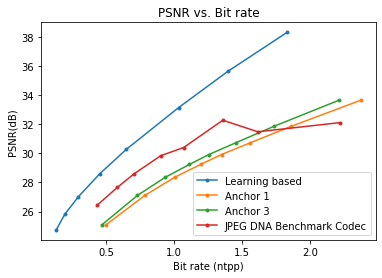

In [160]:
plot_metric('PSNR', 1)

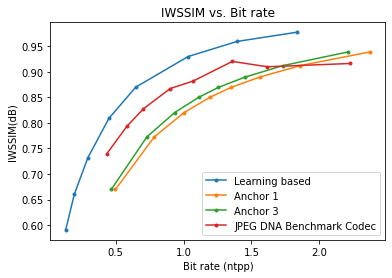

KeyboardInterrupt: 

In [162]:
def plot_all_metrics(img_number): 
    for i in range(1, 25): 
        plot_metric('IWSSIM', i)
        #plot_metric('MSSSIM', i)
        #plot_metric('PSNR', i)

plot_all_metrics(1)

In [151]:
def plot_avg_metric(metric_name): 
    
    # Initialize empty lists to store average metrics and bit rates for each anchor type
    learning_based_avg_metrics = []
    learning_based_avg_bitrates = []
    anchor1_avg_metrics = []
    anchor1_avg_bitrates = []
    anchor3_avg_metrics = []
    anchor3_avg_bitrates = []
    benchmark_codec_avg_metrics = []
    benchmark_codec_avg_bitrates = []
    
    # Loop through quality levels 1-8
    for quality in range(1, 9):
        # Initialize empty lists to store metrics and bit rates for all images at the current quality level
        learning_based_metric = []
        anchor1_metric = [] 
        anchor3_metric = []
        benchmark_codec_metric = []
        learning_based_bitrates = []
        anchor1_bitrates = []
        anchor3_bitrates = []
        benchmark_codec_bitrates = []
        # Loop through images 1-24 (kodak data set)
        for img_id in range(1, 25):
            img, x = get_kodim_tensor(img_id)
            
            # Load image, tensor and dna for the learning-based method and calculate bit rate
            learning_based_img, learning_based_tensor = get_learningbased_tensor(img_id, quality)
            learning_based_dna = get_learningbased_dna(img_id, quality)
            learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))
            
            # Load image, tensor and dna for anchor1, calculate bit rate
            anchor1_img, anchor1_tensor = get_anchor_tensor(1, img_id, quality)
            anchor1_dna = get_anchor_dna(1, img_id, quality)
            anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

            # Load image, tensor and dna for anchor3, calculate bit rate
            anchor3_img, anchor3_tensor = get_anchor_tensor(3, img_id, quality)
            anchor3_dna = get_anchor_dna(3, img_id, quality)
            anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))
            
            # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
            benchmark_codec_img, benchmark_codec_tensor = get_benchmark_tensor(img_id, quality)
            benchmark_codec_dna = get_benchmark_dna(img_id, quality)
            benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))
            
            # Calculate metric for each model and add to corresponding list
            if(metric_name == 'PSNR') : 
                learning_based_metric.append(compute_psnr(x, learning_based_tensor))
                anchor1_metric.append(compute_psnr(x, anchor1_tensor))
                anchor3_metric.append(compute_psnr(x, anchor3_tensor))
                benchmark_codec_metric.append(compute_psnr(x, benchmark_codec_tensor))
            elif (metric_name == 'MSSSIM'): 
                learning_based_metric.append(compute_msssim(x, learning_based_tensor))
                anchor1_metric.append(compute_msssim(x, anchor1_tensor))
                anchor3_metric.append(compute_msssim(x, anchor3_tensor))
                benchmark_codec_metric.append(compute_msssim(x, benchmark_codec_tensor))
            elif (metric_name == 'IWSSIM'): 
                learning_based_metric.append(compute_iwssim(x, learning_based_tensor))
                anchor1_metric.append(compute_iwssim(x, anchor1_tensor))
                anchor3_metric.append(compute_iwssim(x, anchor3_tensor))
                benchmark_codec_metric.append(compute_iwssim(x, benchmark_codec_tensor))
            else:
                print("Invalid argument: " + metric_name + ". The available metrics are PSNR, MSSSIM, IWSSIM.")
                return
        
        # Calculate the average bit rate and metric
        learning_based_avg_bitrates.append(mean(learning_based_bitrates))
        learning_based_avg_metrics.append(mean(learning_based_metric))
        anchor1_avg_bitrates.append(mean(anchor1_bitrates))
        anchor1_avg_metrics.append(mean(anchor1_metric))
        anchor3_avg_bitrates.append(mean(anchor3_bitrates))
        anchor3_avg_metrics.append(mean(anchor3_metric))
        benchmark_codec_avg_bitrates.append(mean(benchmark_codec_bitrates))
        benchmark_codec_avg_metrics.append(mean(benchmark_codec_metric))
    
    # Plot the result
    plt.plot(learning_based_avg_bitrates, learning_based_avg_metrics, label='Learning based', marker='o', markersize=3)
    plt.plot(anchor1_avg_bitrates, anchor1_avg_metrics, label='Anchor 1', marker='o', markersize=3)
    plt.plot(anchor3_avg_bitrates, anchor3_avg_metrics, label='Anchor 3', marker='o', markersize=3)
    plt.plot(benchmark_codec_avg_bitrates, benchmark_codec_avg_metrics, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
    plt.xlabel('Bit rate (ntpp)')
    plt.ylabel(metric_name + '(dB)')
    plt.title(metric_name +' vs. Bit rate')
    plt.legend()
    plt.savefig('plots/avg_'+ metric_name +'.jpeg')
    plt.show()

In [152]:
plot_avg_metric('IWSSIM')

TypeError: can't convert type 'Tensor' to numerator/denominator

In [142]:
def plot_all_average_metrics(): 
    plot_avg_metric('PSNR')
    plot_avg_metric('MSSSIM')
    plot_avg_metric('IWSSIM')

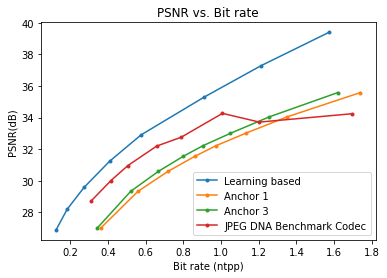

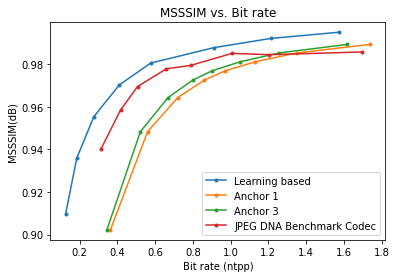

TypeError: can't convert type 'Tensor' to numerator/denominator

In [143]:
plot_all_average_metrics()